# Baseline Models

In [1]:
import sys

sys.path.append('/Users/lars/Documents/test/')

In [2]:
%pip list

Package                       Version
----------------------------- --------------
absl-py                       1.4.0
aioboto3                      12.4.0
aiobotocore                   2.12.3
aiohttp                       3.9.5
aioitertools                  0.11.0
aiosignal                     1.3.1
annotated-types               0.6.0
anyio                         4.3.0
appnope                       0.1.4
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow                         1.3.0
asttokens                     2.4.1
astunparse                    1.6.3
async-lru                     2.0.4
async-timeout                 4.0.3
attrs                         23.2.0
Babel                         2.15.0
beautifulsoup4                4.12.3
bleach                        6.1.0
boto3                         1.34.69
botocore                      1.34.69
cachetools                    5.3.3
certifi                       2024.2.2
cffi                          1.16.0
c

In [3]:
#%pip install /Users/lars/Downloads/tensorflow_text-2.15.0-cp310-cp310-macosx_11_0_arm64.whl

Processing /Users/lars/Downloads/tensorflow_text-2.15.0-cp310-cp310-macosx_11_0_arm64.whl
tensorflow-text is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
You should consider upgrading via the '/Users/lars/Documents/test/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
#%pip install -U "tf-models-official==2.15.*"

You should consider upgrading via the '/Users/lars/Documents/test/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Path variables for datasets
directory = "/Users/lars/Documents/Uni/Masterarbeit/Online_Process_Concept_Drift"
path_raw = "/data/raw/"
path_interim = "/data/interim/"
path_processed = "/data/processed/"

In [ ]:
# Lookup: Train/Val sequence length for all datasets

#train_max_length_helpdesk = 36
#val_max_length_helpdesk = 32

#train_max_length_bpic2012 = 511
#val_max_length_bpic2012 = 526

#train_max_length_bpic2018 = 242
#val_max_length_bpic2018 = 242

In [3]:
import os
import time
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from src.data.data_manager import data_loader
from src.models.baseline_models import LongformerPreprocessorStatic, LongformerModelBuilderStatic, BERTPreprocessorStatic, BERTModelBuilderStatic, MetricsCallbackStatic, ensure_one_dimensional

TensorFlow version: 2.15.0


/Users/lars/Documents/test/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#Verify GPU is used

print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available: ", len(gpus))
if gpus:
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPU available")

# Verify GPU utilization with a simple computation
with tf.device('/GPU:0'):
    a = tf.random.normal([10000, 10000])
    b = tf.random.normal([10000, 10000])
    start_time = time.time()
    c = tf.matmul(a, b)
    print("GPU computation time: ", time.time() - start_time, "seconds")

TensorFlow version: 2.15.0
GPUs available:  0
No GPU available
GPU computation time:  2.8520641326904297 seconds


In [6]:
train_tensor = data_loader(directory, path_interim, "Helpdesk_train")
val_tensor = data_loader(directory, path_interim, "Helpdesk_val")
test_tensor = data_loader(directory, path_interim, "Helpdesk_test")

In [7]:
# Lookup: Train/Val sequence length for all datasets

#train_max_length_helpdesk = 36
#val_max_length_helpdesk = 32

#train_max_length_bpic2012 = 511
#val_max_length_bpic2012 = 526

#train_max_length_bpic2018 = 242
#val_max_length_bpic2018 = 242

In [8]:
# Lookup: Number of labels per dataset

# helpdesk = 10
# bpic2012 = 24
# bpic2018 = 42

In [9]:
train_tensor

,Prefix_Trace,Next_Activity
0,assign-seriousness,take-in-charge-ticket
1,assign-seriousness take-in-charge-ticket,take-in-charge-ticket
2,assign-seriousness take-in-charge-ticket take-...,resolve-ticket
3,assign-seriousness take-in-charge-ticket take-...,closed
4,assign-seriousness take-in-charge-ticket take-...,end
...,...,...
13170,assign-seriousness,take-in-charge-ticket
13171,assign-seriousness take-in-charge-ticket,wait
13172,assign-seriousness take-in-charge-ticket wait,resolve-ticket
13173,assign-seriousness take-in-charge-ticket wait ...,closed


---
## BERT Model

### Preprocessing

In [ ]:
preprocessor = BERTPreprocessorStatic()
preprocessor.fit_activity_labels(train_tensor)
bert_input_train = preprocessor.preprocess(train_tensor)
bert_input_val = preprocessor.preprocess(val_tensor)

In [ ]:
max_length = preprocessor.max_length
max_length

#max_length = 128 # Backup in case Preprocesaor is not loaded

In [ ]:
# Save the tokenized sequences as pkl file to avoid need of tokenizing in later sessions

#Train data
with open('/Users/lars/Documents/test/data/processed/Helpdesk_train_input.pkl', 'wb') as file:
    pickle.dump(bert_input_train, file)

#Val data
with open('/Users/lars/Documents/test/data/processed/Helpdesk_val_input.pkl', 'wb') as file:
    pickle.dump(bert_input_val, file)

In [ ]:
# Load the tokenized sequences again

#Train data
with open('/Users/lars/Documents/test/data/processed/Helpdesk_train_input.pkl', 'rb') as file:
    loaded_data_dict_train = pickle.load(file)

#Val data
with open('/Users/lars/Documents/test/data/processed/Helpdesk_val_input.pkl', 'rb') as file:
    loaded_data_dict_val = pickle.load(file)

# Ensure the tensors are converted back correctly
loaded_data_dict_train = {key: tf.convert_to_tensor(value) for key, value in loaded_data_dict_train.items()}

loaded_data_dict_val = {key: tf.convert_to_tensor(value) for key, value in loaded_data_dict_val.items()}


---

### Tune model

In [ ]:
# Set evnviroment variables to reduce mmodel's memory usage and increase efficency

# Set the environment variable for GPU memory management
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Enable mixed precision for better performance and reduced memory usage
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Clear any existing GPU memory state
tf.keras.backend.clear_session()

# Reduce TensorFlow logging verbosity
tf.get_logger().setLevel('ERROR')

In [ ]:
# Set model parameters
num_classes = 10 
max_length = 36
batch_size = 16

# URLs for the BERT model and preprocessor
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
# Initialize and create model

model_builder = BERTModelBuilderStatic(preprocessor_url=tfhub_handle_preprocess, 
                                 encoder_url=tfhub_handle_encoder, 
                                 num_classes=num_classes,
                                 max_length=max_length)  # Use original max_length

model = model_builder.create_model()
model.summary()

In [ ]:
# Prepare dataset and ensure that data is in appropriate formate to be used as input for BERT base

train_data = {
    'input_mask': bert_input_train['input_mask'],
    'input_type_ids': bert_input_train['input_type_ids'],
    'input_word_ids': bert_input_train['input_word_ids']
}

train_labels = bert_input_train['labels']

val_data = {
    'input_mask': bert_input_val['input_mask'],
    'input_type_ids': bert_input_val['input_type_ids'],
    'input_word_ids': bert_input_val['input_word_ids'],
}

val_labels = bert_input_val['labels']

# Ensure labels are in the shape (None,) and integer-encoded
train_labels = tf.squeeze(train_labels)
val_labels = tf.squeeze(val_labels)

# Apply the function to labels
train_labels = ensure_one_dimensional(train_labels)
val_labels = ensure_one_dimensional(val_labels)

# Confirm the shapes again
print(f"After ensuring one-dimensional, shape of train_labels: {train_labels.shape}")
print(f"After ensuring one-dimensional, shape of val_labels: {val_labels.shape}")

# Shuffle the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).shuffle(buffer_size=len(train_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# No need to shuffle the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Add custom callback metrics to model and fine-tune it

# Train the model with the custom metrics callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

metrics_callback = MetricsCallbackStatic(validation_data=val_dataset)

history_helpdesk = model.fit(
    train_dataset,
    epochs=5,  # Increase the number of epochs
    validation_data=val_dataset,
    callbacks=[metrics_callback, early_stopping_callback]
)

In [ ]:
# After training, access the stored metrics
print("F1 Scores:", metrics_callback.f1_scores)
print("Precisions:", metrics_callback.precisions)
print("Recalls:", metrics_callback.recalls)
print("History:", history_helpdesk.history)

In [ ]:
# Save the trained model with a specific name
model_name = "bert_base_model_bpic2018"
model.save(f'/home/lars.gsaenger/test/models/models_pretrained/{model_name}')

# Save the training history
import pickle
with open(f'/home/lars.gsaenger/test/models/models_pretrained/history_bpic2018.pkl', 'wb') as file:
    pickle.dump(history_helpdesk.history, file)


In [ ]:
#BPIC2018
# Load the saved model
loaded_model = tf.keras.models.load_model(f'/home/lars.gsaenger/test/models/models_pretrained/{model_name}')

# Load the training history
with open('/home/lars.gsaenger/test/models/models_pretrained/history_bpic2018.pkl', 'rb') as file:
    history_helpdesk = pickle.load(file)

# Function to plot training history
def plot_training_history(history, title):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'Training and validation accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history_helpdesk, "BPIC2018")

## Longformer

### Preprocessing

In [ ]:
preprocessor = LongformerPreprocessorStatic()
preprocessor.fit_activity_labels(train_tensor)
bert_input_train = preprocessor.preprocess(train_tensor)
bert_input_val = preprocessor.preprocess(val_tensor)

In [ ]:
max_length = preprocessor.max_length
max_length

#max_length = 128 # Backup in case Preprocesaor is not loaded

### Train Longformer

In [ ]:
# Setup enviroment parameters to optimize memory usage and efficency

# Clear any existing GPU memory state
tf.keras.backend.clear_session()

# Set the environment variable for GPU memory management
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Reduce TensorFlow logging verbosity
tf.get_logger().setLevel('ERROR')

In [ ]:
# Set model parameters

max_length = 36
num_classes = 10
batch_size=4

In [ ]:
# Initialize the model and print summary

model_builder = LongformerModelBuilderStatic(model_name='allenai/longformer-base-4096', num_classes=num_classes)
model = model_builder.create_model(max_length=max_length)
model.summary()

In [ ]:
# Prepare dataset and ensure that data is in appropriate formate to be used as input for BERT base

train_data = {
    'input_ids': bert_input_train['input_ids'],  # Assuming input_word_ids correspond to input_ids
    'attention_mask': bert_input_train['attention_mask']
}

train_labels = bert_input_train['labels']

val_data = {
    'input_ids': bert_input_val['input_ids'],  # Assuming input_word_ids correspond to input_ids
    'attention_mask': bert_input_val['attention_mask']
}

val_labels = bert_input_val['labels']

# Ensure labels are in the shape (None,) and integer-encoded
train_labels = tf.squeeze(train_labels)
val_labels = tf.squeeze(val_labels)

# Apply the function to labels
train_labels = ensure_one_dimensional(train_labels)
val_labels = ensure_one_dimensional(val_labels)

# Confirm the shapes again
print(f"After ensuring one-dimensional, shape of train_labels: {train_labels.shape}")
print(f"After ensuring one-dimensional, shape of val_labels: {val_labels.shape}")

# Shuffle the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).shuffle(buffer_size=len(train_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# No need to shuffle the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Add custom callback metrics to model and fine-tune it

# Define early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

metrics_callback = MetricsCallbackStatic(validation_data=val_dataset)

# Assuming you have defined your model (e.g., Longformer model)
history_helpdesk = model.fit(
    train_dataset,
    epochs=2,  # Increase the number of epochs if necessary
    validation_data=val_dataset,
    callbacks=[metrics_callback, early_stopping_callback]
)

In [ ]:
# After training, access the stored metrics
print("F1 Scores:", metrics_callback.f1_scores)
print("Precisions:", metrics_callback.precisions)
print("Recalls:", metrics_callback.recalls)
print("History:", history_helpdesk.history)

In [ ]:
# Save the trained model with a specific name
model_name = "bert_base_model_bpic2018"
model.save(f'/home/lars.gsaenger/test/models/models_pretrained/{model_name}')

# Save the training history
import pickle
with open(f'/home/lars.gsaenger/test/models/models_pretrained/history_bpic2018.pkl', 'wb') as file:
    pickle.dump(history_helpdesk.history, file)


In [ ]:
#BPIC2018
# Load the saved model
loaded_model = tf.keras.models.load_model(f'/home/lars.gsaenger/test/models/models_pretrained/{model_name}')

# Load the training history
with open('/home/lars.gsaenger/test/models/models_pretrained/history_bpic2018.pkl', 'rb') as file:
    history_helpdesk = pickle.load(file)

# Function to plot training history
def plot_training_history(history, title):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'Training and validation accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history_helpdesk, "BPIC2018")

---

## BERT Architecture Visuals

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                            

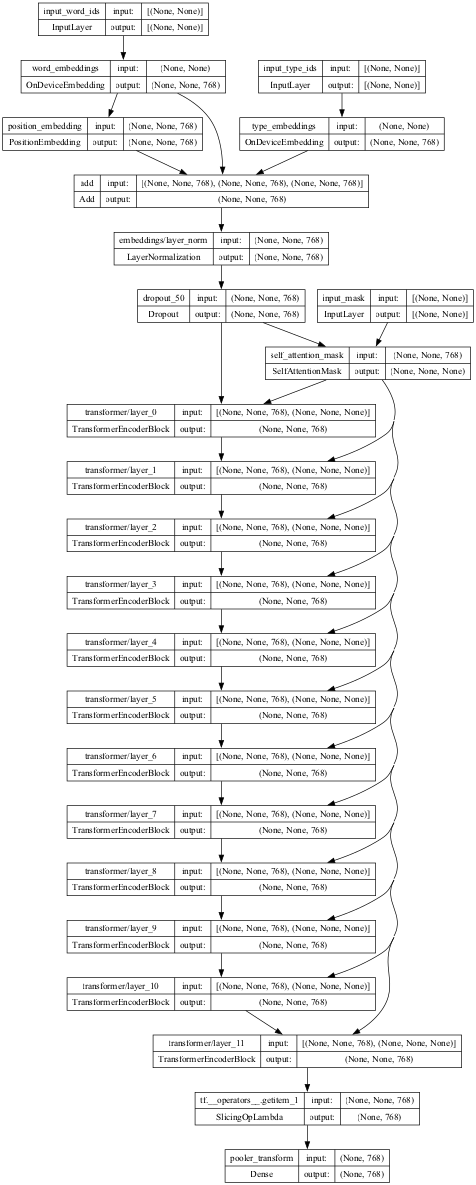

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_models as tfm

def create_detailed_bert_model(num_classes, max_length=128):
    # Define the input layers for tokenized inputs
    input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_type_ids")

    # Define the encoder configuration
    config_dict = {
        'vocab_size': 30522,
        'hidden_size': 768,
        'num_hidden_layers': 12,
        'num_attention_heads': 12,
        'intermediate_size': 3072,
        'hidden_act': 'gelu',
        'hidden_dropout_prob': 0.1,
        'attention_probs_dropout_prob': 0.1,
        'max_position_embeddings': 512,
        'type_vocab_size': 2,
        'initializer_range': 0.02,
        'layer_norm_eps': 1e-12
    }

    encoder_config = tfm.nlp.encoders.EncoderConfig({
        'type': 'bert',
        'bert': config_dict
    })

    # Build the BERT encoder
    bert_encoder = tfm.nlp.encoders.build_encoder(encoder_config)

    # Pass the inputs to the BERT layer
    bert_outputs = bert_encoder([input_word_ids, input_mask, input_type_ids])
    
    # Get the pooled output from BERT
    pooled_output = bert_outputs['pooled_output']
    
    # Add a dropout layer for regularization
    dropout = tf.keras.layers.Dropout(rate=0.1)(pooled_output)
    
    # Output layer for classification
    output = tf.keras.layers.Dense(num_classes, activation='softmax', name="classifier")(dropout)

    # Create the model
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    
    return model, bert_encoder

# Example usage
num_classes = 10  # Replace with the actual number of classes

# Create the detailed BERT model
model, bert_encoder = create_detailed_bert_model(num_classes)

# Print the model summary
model.summary()

# Plot the detailed model architecture
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)
